In [155]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings("ignore")
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn import model_selection
import import_ipynb
from save_lib import save_RF_model
from save_lib import save_NN_model
import time
from sklearn.neural_network import MLPRegressor
import os
from sklearn.preprocessing import LabelEncoder
import theano
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

In [156]:
df_merge = pd.read_excel('prepared_hard.xlsx')
df_merge_valid = pd.read_excel('prepared_hard_valid.xlsx')

In [157]:
ls_steel = pd.get_dummies(df_merge['марка стали']).columns
ls_steel = list(ls_steel)

In [158]:
'''
    70.5(690.9)    30ХГМА
    77.75(762)     37Г2Ф
    69.64(682.5)   30Г2
''' 
d = {
#     'НД (гост, ту)' : [ ]
#     'марка стали' : [35, 52, 27], #'30ХГМА', '37Г2Ф', '30Г2'
    '1 зона фактическая температура закалка' : [860, 840, 850], 
#     '2 зона по ВТР закалка' : [860, 840, 850],
    '3 зона по ВТР закалка' : [860, 850, 860], 
#     'Температура трубы на выгрузке из печи закалки' : [855, 835, 850],
    'Скорость прохождения трубы через спрейер, м/с' : [0.15, 0.28, 0.37],
#     't˚ C трубы после спреера' : [106, 100, 75],
    '1 зона ВТР и уставка отпуск' : [675, 664, 600], 
#     '2 зона ВТР и уставка отпуск' : [675, 664, 600], 
    '3 зона ВТР и уставка отпуск' : [650, 653, 593],
#     '4 зона ВТР и уставка отпуск' : [650, 653, 593],
    '5 зона ВТР и уставка отпуск' : [633, 637, 580], 
#     'Температура трубы на выгрузке из печи отпуска' : [660, 660, 575],
    'шаг балок закалочная печь, сек' : [37, 40, 30], 
    'шаг балок отпускная печь, сек' : [37, 31, 30],
    'диаметр' : [187.71, 88.9, 168.28], 
    'толщина стенки' : [16.5, 12.2, 8.94], 
    'C' : [0.29, 0.37, 0.28], 
    'Mn' : [0.92, 1.49, 1.33], 
    'Si' : [0.26, 0.28, 0.26], 
    'P' : [0.009, 0.011, 0.009], 
#     'S' : [0.005, 0.007, 0.007],
    'Cr' : [0.68, 0.14, 0.1], 
    'Ni' : [0.13, 0.13, 0.13], 
    'Cu' : [0.15, 0.13, 0.19], 
    'Al' : [0.03, 0.03, 0.03], 
#     'V' : [0.007, 0.09, 0.005], 
#     'Ti' : [0, 0.006, 0.007], 
#     'Nb' : [0, 0.0002, 0.006], 
#     'Mo' : [0.16, 0.0009, 0.015], 
    'N' : [0.008, 0.006, 0.009], 
#     'B': [0, 0, 0.0005],
    'Параметр отпуск' : [25.826798, 25.757751, 24.078837],
    'Параметр закалка' : [849.279448, 836.289772, 839.665069],
#     'Тип предела текучести 0.2': [1, 1, 1],
#     'Тип предела текучести 0.5': [0, 0, 0],
#     'Тип предела текучести 0.6': [0, 0, 0],
    'C-coef': [0.39, 0.37, 0.31],
    'ICD':[4.133959, 1.695309, 1.452618]
}

df_valid = pd.DataFrame(data = d)

In [173]:
ls_need_col = [
#     'Поставщик',
#     'НД (гост, ту)',
#     'ГОСТ, ТУ',
#     'Дата форм. цехом',
     'марка стали',
#     '№ плавки',
#     'кол-во, шт.',
#     '№ партии',
    '1 зона по ВТР закалка', 
#     '1 зона уставка закалка',
#     '1 зона фактическая температура закалка', 
#     '2 зона по ВТР закалка',
    '3 зона по ВТР закалка', 
#     '3 зона уставка закалка',
#     '3 зона фактическая температура закалка',
#     'Температура трубы на выгрузке из печи закалки',
    'Скорость прохождения трубы через спрейер, м/с',
#     't˚ C трубы после спреера', 
#     'Расход воды на закалочный спрейер, м3',
#     'время выдержки в закалочной ванне, сек.',
#     't˚ C воды в закалочной ванне', 
#     't˚ C трубы после ванны',
    '1 зона ВТР и уставка отпуск', 
#     '1 зона фактическая температура отпуск',
#     '2 зона ВТР и уставка отпуск', 
    '3 зона ВТР и уставка отпуск',
#     '3 зона фактическая температура отпуск', 
#     '4 зона ВТР и уставка отпуск',
    '5 зона ВТР и уставка отпуск', 
#     '5 зона фактическая температура отпуск',
#     'Температура трубы на выгрузке из печи отпуска',
    'шаг балок закалочная печь, сек', 
    'шаг балок отпускная печь, сек',
    'диаметр', 
    'толщина стенки', 
    'C', 
    'Mn', 
    'Si', 
    'P', 
#     'S',
    'Cr', 
    'Ni', 
    'Cu', 
    'Al', 
#     'V', 
#     'Ti', 
#     'Nb', 
#     'Mo', 
    'N', 
#     'B',
    'Параметр отпуск',
    'Параметр закалка',
#     'Тип предела текучести 0.2',
#     'Тип предела текучести 0.5',
#     'Тип предела текучести 0.6',
    'C-coef',
    'ICD'
]

df_prepared_merge = pd.DataFrame()

for col in ls_need_col+['Предел текучести', 'Врем. сопротивление']:
    df_prepared_merge[col] = df_merge[col]
    
df_prepared_valid = pd.DataFrame()

for col in ls_need_col+['Предел текучести', 'Врем. сопротивление']: #ls_steel
    df_prepared_valid[col] = df_merge_valid[col]

ls_need_col.remove('марка стали')

In [189]:
arr_df_steel = []
arr_valid_steel = []
for steel in ls_steel:
    arr_df_steel.append(df_prepared_merge[df_prepared_merge['марка стали'] == steel])
    arr_valid_steel.append(df_prepared_valid[df_prepared_valid['марка стали'] == steel])

len(arr_df_steel)

51

In [190]:
for df in arr_df_steel:
    print(df.shape, df['марка стали'].values[0])

(2, 26) 08ХГМФБ
(2, 26) 08ХГФБ
(626, 26) 09Г2С
(2, 26) 09ГФБ
(6, 26) 10Г2
(3, 26) 12ГА
(3176, 26) 13ХФА
(27, 26) 13ХФА-3
(4, 26) 13ХФА-4
(270, 26) 18Х3МФБ
(2487, 26) 18ХМФБ
(376, 26) 20
(99, 26) 20А
(28, 26) 20А-1
(165, 26) 20А-У
(25, 26) 20А-пр
(12, 26) 20Г2
(2, 26) 20Г2-1
(24, 26) 20ФА
(10, 26) 20ХФА
(5, 26) 26Г1ФМ
(14123, 26) 30Г2
(1445, 26) 30Г2-2
(415, 26) 30Г2-3
(53, 26) 30Г2-5
(685, 26) 30Г2-8
(7, 26) 30Г2Ф
(1, 26) 30Г3
(299, 26) 30ХГМА
(29, 26) 30ХГМА-1
(82, 26) 30ХГМА-4
(19, 26) 30ХГСА
(148, 26) 30ХМА
(9, 26) 32Г1
(15, 26) 32Г2
(2, 26) 32Г2СФБ
(9, 26) 32Х1МФ
(9, 26) 32Х1МФ-1
(324, 26) 32ХА
(6, 26) 32ХНМ
(2, 26) 36ХГ2СФБ
(1, 26) 36ХГФ
(4990, 26) 37Г2Ф
(1, 26) 37Г2Ф-М
(1, 26) 38Г2-4
(655, 26) 38Г2С
(6, 26) 38Г2С-3
(74, 26) 38Г2С-4
(48, 26) 38Г2С-9
(2, 26) 38Г2СФ
(13, 26) Д


In [191]:
len_arr = []
for x in range(0,len(arr_df_steel)):
    len_arr.append(x)

In [192]:
len_arr.reverse()

In [193]:
for i in len_arr:
    arr_df_steel[i] = arr_df_steel[i].dropna()
    arr_df_steel[i] =  arr_df_steel[i].reset_index(drop=True)
    arr_valid_steel[i] = arr_valid_steel[i].dropna()
    arr_valid_steel[i] =  arr_valid_steel[i].reset_index(drop=True)

for i in len_arr:
    if (arr_valid_steel[i].shape[0] < 2) | (arr_df_steel[i].shape[0] < 50):
        del arr_df_steel[i]
        del arr_valid_steel[i]

In [194]:
len(arr_df_steel)

9

In [195]:
for i in arr_df_steel:
    print(i.shape,i['марка стали'].values[0])

ls_steel_zip = []
print('\nValid:')
for i in arr_valid_steel:
    print(i.shape,i['марка стали'].values[0])
    ls_steel_zip.append(i['марка стали'].values[0])


(420, 26) 09Г2С
(2625, 26) 13ХФА
(2229, 26) 18ХМФБ
(227, 26) 20
(11565, 26) 30Г2
(397, 26) 30Г2-8
(98, 26) 30ХГМА
(58, 26) 30ХГМА-4
(1950, 26) 37Г2Ф

Valid:
(23, 26) 09Г2С
(11, 26) 13ХФА
(19, 26) 18ХМФБ
(21, 26) 20
(234, 26) 30Г2
(45, 26) 30Г2-8
(12, 26) 30ХГМА
(2, 26) 30ХГМА-4
(9, 26) 37Г2Ф


In [196]:
scaler = StandardScaler() 
for valid in arr_valid_steel:
    y_valid = pd.DataFrame()
    X_valid = pd.DataFrame()

    target = 'Предел текучести'
    # target = 'Врем. сопротивление'
    y_valid[target] = valid[target]
    
    for i in ls_need_col:
        X_valid[i] = valid[i]
    print(X_valid.shape)
    X_valid = scaler.fit_transform(X_valid, y_valid)

(23, 23)
(11, 23)
(19, 23)
(21, 23)
(234, 23)
(45, 23)
(12, 23)
(2, 23)
(9, 23)


In [197]:
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=500,
#                                    test_size=0.2, random_state=0)
# title = 'title'
# plot_learning_curve(rfc, title, X, y, cv=cv, ylim=(0.7, 1.01), n_jobs=-1)

09Г2С
-3.22861712085 4.15525391976 21.2310152608 -0.000276039701985
мПа:
 [ 553.9496621   551.4210122   551.38756551]
кгс:
 [ 56.52547572  56.26745022  56.2640373 ]
Модель сохранена
13ХФА
0.157862011277 1.12611029117 1.5758493647 0.629322847206
мПа:
 [ 557.78487625  556.43581277  555.09000166]
кгс:
 [ 56.91682411  56.77916457  56.6418369 ]
Модель сохранена
18ХМФБ
0.869718853384 1.51812160665 4.29004754718 0.956038442439
мПа:
 [ 708.24473161  707.18547268  706.45465849]
кгс:
 [ 72.26987057  72.16178293  72.08721005]
Модель сохранена
20
-0.821763947447 1.68606362605 4.92826392133 0.511542987045
мПа:
 [ 483.43430389  483.73862662  483.91207106]
кгс:
 [ 49.33003101  49.36108435  49.37878276]
Модель сохранена
30Г2
0.147366037868 5.19854184119 43.5379494688 0.510370896424
мПа:
 [ 739.6926051   739.97240252  739.89056958]
кгс:
 [ 75.47883726  75.50738801  75.49903771]
Модель сохранена
30Г2-8
-1.04269085924 4.8981230108 37.8654707738 0.135300982477
мПа:
 [ 693.49908329  693.70329454  693.52440

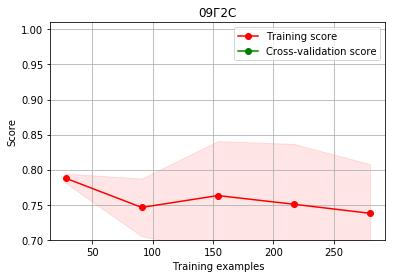

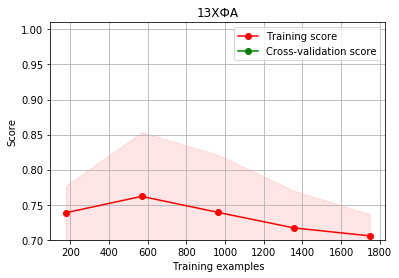

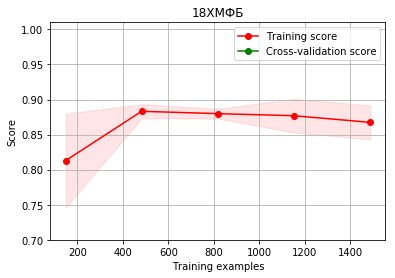

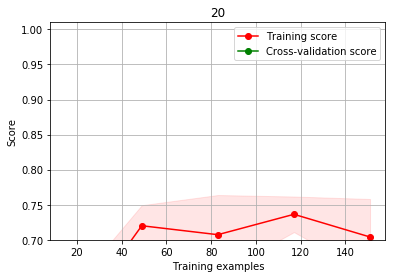

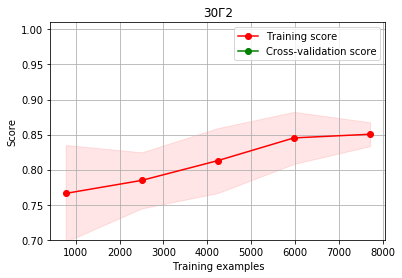

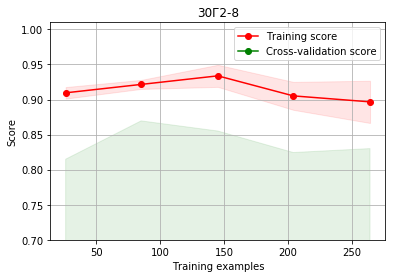

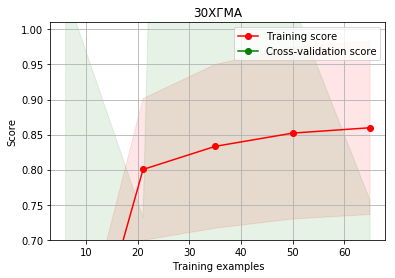

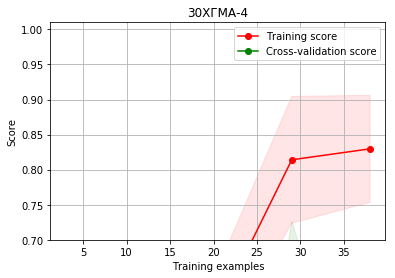

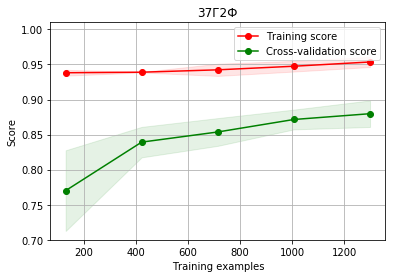

In [253]:
label = LabelEncoder() 
scaler = StandardScaler()  

for df, valid in zip(arr_df_steel, arr_valid_steel):
    print(df['марка стали'].values[0])

    y = pd.DataFrame()
    X = pd.DataFrame()
    y_valid = pd.DataFrame()
    X_valid = pd.DataFrame()
    
#     target = 'Предел текучести'
    target = 'Врем. сопротивление'

    y[target] = df[target]
    y_valid[target] = valid[target]

    for i in ls_need_col: #+ls_steel:
        X[i] = df[i]

    for i in ls_need_col: #+ls_steel:
        X_valid[i] = valid[i]
    
    X_valid = X_valid.dropna()
    X = scaler.fit_transform(X, y)
    X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)
    
    rfc = RandomForestRegressor(max_features = 10, max_depth = 15, min_samples_leaf = 2, n_estimators=700, random_state=42)
    rfc.fit(X, y)
    model_selection.learning_curve(rfc, X, y)
    y_pred = rfc.predict(X_valid)
    scr = rfc.score(X_valid, y_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    mse = mean_squared_error(y_valid, y_pred)
    corr = np.corrcoef(y_valid.T, y_pred)
    print(scr, mae, mse, corr[0][1])
    title = str(df['марка стали'].values[0])
    plot_learning_curve(rfc, title, X, y, ylim=(0.7, 1.01), n_jobs=-1)
    y_predict = rfc.predict(df_valid)
    print('мПа:\n',y_predict*9.8)
    print('кгс:\n',y_predict)
    score_data = {
    'MSE':[mse],
    'MAE':[mae],
    'corr':[corr]
    }

    score_df = pd.DataFrame(score_data)
    
    ab = pd.concat([score_df,tmp_df])
    
    save_RF_model(rfc, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))

In [37]:
def ru2en(st):
    dict_ru2en = {
        '09Г2С':'09g2s',
        '13ХФА':'13hfa',
        '18ХМФБ':'18hmfb',
        '20':'20',
        '30Г2':'30g2',
        '30Г2-8':'30g2-8',
        '30ХГМА':'30hgma',
        '30ХГМА-4':'30hgma-4',
        '37Г2Ф':'37g2f',
        '38Г2С-9':'38g2s-9'
    }
    return dict_ru2en[st]

## Обучение
    Цикл по всем отобранным маркам стали и валидации для них. Получем отдельные модели одинаковой архитектуры

In [ ]:
now_code = datetime.now()
time_code = "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

In [154]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

for df, valid in zip(arr_df_steel, arr_valid_steel):
    print(df['марка стали'].values[0])

    y = pd.DataFrame()
    X = pd.DataFrame()
    y_valid = pd.DataFrame()
    X_valid = pd.DataFrame()
    
    target = 'Предел текучести'
#     target = 'Врем. сопротивление'

    y[target] = df[target]
    y_valid[target] = valid[target]

    for i in ls_need_col: #+ls_steel:
        X[i] = df[i]

    for i in ls_need_col: #+ls_steel:
        X_valid[i] = valid[i]
    
    X_valid = X_valid.dropna()
    X = scaler.fit_transform(X, y)
    X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)
    
    model = Sequential()
    model.add(Dense(units=32, input_dim=X.shape[1]))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(units=4))
    model.add(Activation('tanh'))
    model.add(Dropout(0.3))
    
#     model.add(Dense(units=16, input_dim=X.shape[1]))
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.6))
#     model.add(Dense(units=2))
#     model.add(Activation('tanh'))

    model.add(Dense(units=1))
    model.compile(
            loss=keras.losses.mean_squared_error,
            # loss=keras.losses.mean_absolute_error,
            metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
            optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.9, epsilon=1e-5, decay=1e-5)
            )
    model.fit(X, y, batch_size = 256, epochs=100, shuffle=True, verbose=0)

    y_predict = model.predict(X_valid)
    tmp_df = pd.DataFrame()
    tmp_df['predict'] = list(y_predict)
    tmp_df['valid'] = y_valid.values
    mae = mean_absolute_error(y_predict, y_valid)
    mse = mean_squared_error(y_predict, y_valid)
    corr = pearsonr(y_predict, y_valid)
    print('valid:\n',mae, mse, corr)
    y_pred = model.predict(df_valid)
    print('\non 3 str of March\nмПа:\n',y_pred*9.8)
    print('кгс:\n',y_pred)
    score_data = {
    'MSE':[mse],
    'MAE':[mae],
    'corr':[corr]
    }

    score_df = pd.DataFrame(score_data)
    
    ab = pd.concat([score_df,tmp_df])
    save_NN_model(model, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))

09Г2С
valid:
 19.8742358996 397.370886629 (array([-0.07218141]), array([ 0.74344668]))

on 3 str of March
мПа:
 [[ 199.14639282]
 [ 199.14715576]
 [ 199.14637756]]
кгс:
 [[ 20.32106018]
 [ 20.32113838]
 [ 20.32105827]]
Модель сохранена
13ХФА
valid:
 2.28630679116 9.1319768659 (array([  2.38439831e-15]), array([ 1.]))

on 3 str of March
мПа:
 [[ 400.90145874]
 [ 400.9012146 ]
 [ 400.90106201]]
кгс:
 [[ 40.90830994]
 [ 40.90828705]
 [ 40.90827179]]
Модель сохранена
18ХМФБ
valid:
 6.19065811518 76.9461361229 (array([  4.10568903e-16]), array([ 1.]))

on 3 str of March
мПа:
 [[ 637.92285156]
 [ 637.92285156]
 [ 637.92285156]]
кгс:
 [[ 65.09416962]
 [ 65.09416962]
 [ 65.09416962]]
Модель сохранена
20
valid:
 27.0473545165 742.412350039 (array([ 0.5027436]), array([ 0.02018762]))

on 3 str of March
мПа:
 [[ 98.69077301]
 [ 98.69078064]
 [ 98.69078064]]
кгс:
 [[ 10.07048702]
 [ 10.07048798]
 [ 10.07048798]]
Модель сохранена
30Г2
valid:
 7.25664117027 94.5346174085 (array([ nan]), array([ 1.])

# Отдельные модели на каждую марку стали

## 09Г2С

In [ ]:
now_code = datetime.now()
time_code = "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

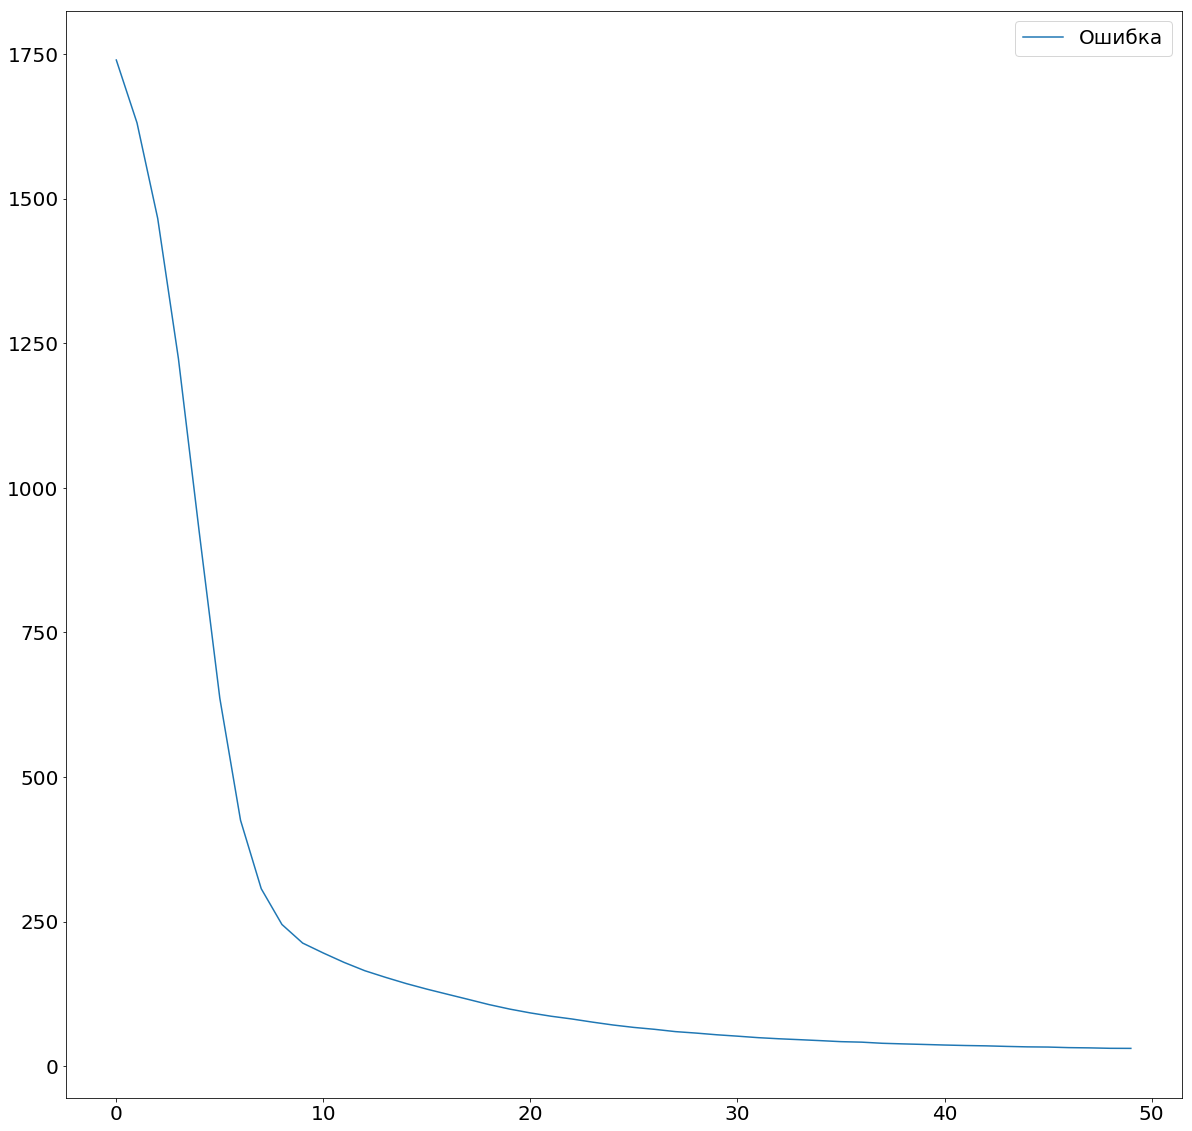

420/420 [==============================] - 1s 2ms/step - loss: 30.8869 - mean_absolute_error: 4.0278
valid:
 8.70884066043 83.7578948522 (array([ 0.28407022]), array([ 0.18896841]))

on 3 str of March
мПа:
 [[ 47416.61328125]
 [ 47862.4921875 ]
 [ 44743.421875  ]]
кгс:
 [[ 4838.4296875 ]
 [ 4883.92773438]
 [ 4565.65527344]]
Модель сохранена


In [265]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

df = arr_df_steel[0]
valid = arr_valid_steel[0]

y = pd.DataFrame()
X = pd.DataFrame()
y_valid = pd.DataFrame()
X_valid = pd.DataFrame()

target = 'Предел текучести'
#     target = 'Врем. сопротивление'

y[target] = df[target]
y_valid[target] = valid[target]

for i in ls_need_col: #+ls_steel:
    X[i] = df[i]

for i in ls_need_col: #+ls_steel:
    X_valid[i] = valid[i]

X = scaler.fit_transform(X, y)
X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)

model = Sequential()
model.add(Dense(units=8, input_dim=X.shape[1]))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=4))
# model.add(Activation('tanh'))
# model.add(Dropout(0.1))

model.add(Dense(units=1))
model.compile(
        loss=keras.losses.mean_squared_error,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
        optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.97, epsilon=1e-5, decay=1e-5)
        )
model.fit(X, y, batch_size = 128, epochs=50, shuffle=True, callbacks=[plot_losses])

y_predict = model.predict(X_valid)
tmp_df = pd.DataFrame()
tmp_df['predict'] = list(y_predict)
tmp_df['valid'] = y_valid.values
mae = mean_absolute_error(y_predict, y_valid)
mse = mean_squared_error(y_predict, y_valid)
corr = pearsonr(y_predict, y_valid)
print('valid:\n',mae, mse, corr)
y_pred = model.predict(df_valid)
print('\non 3 str of March\nмПа:\n',y_pred*9.8)
print('кгс:\n',y_pred)
score_data = {
'MSE':[mse],
'MAE':[mae],
'corr':[corr]
}

score_df = pd.DataFrame(score_data)
    
ab = pd.concat([score_df,tmp_df])
save_NN_model(model, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))

In [264]:
%matplotlib inline
#увеличим дефолтный размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 20
rcParams.update({'font.size': 20})

import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="Ошибка")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

# class PlotLearning(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.i = 0
#         self.x = []
#         self.losses = []
#         self.val_losses = []
#         self.acc = []
#         self.val_acc = []
#         self.fig = plt.figure()
        
#         self.logs = []

#     def on_epoch_end(self, epoch, logs={}):
        
#         self.logs.append(logs)
#         self.x.append(self.i)
#         self.losses.append(logs.get('loss'))
#         self.val_losses.append(logs.get('val_loss'))
#         self.acc.append(logs.get('acc'))
#         self.val_acc.append(logs.get('val_acc'))
#         self.i += 1
#         f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
#         clear_output(wait=True)
        
#         ax1.set_yscale('log')
#         ax1.plot(self.x, self.losses, label="loss")
#         ax1.plot(self.x, self.val_losses, label="val_loss")
#         ax1.legend()
        
#         ax2.plot(self.x, self.acc, label="accuracy")
#         ax2.plot(self.x, self.val_acc, label="validation accuracy")
#         ax2.legend()
        
#         plt.show();
        
# plot_losses = PlotLearning()

## 13ХФА

In [251]:
now_code = datetime.now()
time_code ='MAE1.9_MSE6_13hfa_'+ "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

'MODELS_Code/MAE1.9_MSE6_13hfa_5_4date14_6_7_8time.py'

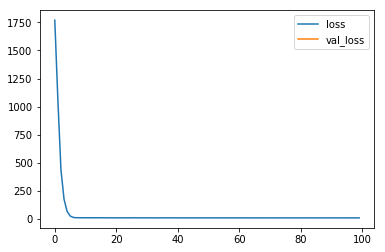

2625/2625 [==============================] - 0s 155us/step - loss: 9.6273 - mean_absolute_error: 2.3781
valid:
 2.00373290126 6.06692467279 (array([ 0.49305185]), array([ 0.12331316]))

on 3 str of March
мПа:
 [[-117.84980011]
 [-117.84980011]
 [-117.84980011]]
кгс:
 [[-12.02548981]
 [-12.02548981]
 [-12.02548981]]


In [255]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

df = arr_df_steel[1]
valid = arr_valid_steel[1]

y = pd.DataFrame()
X = pd.DataFrame()
y_valid = pd.DataFrame()
X_valid = pd.DataFrame()

target = 'Предел текучести'
#     target = 'Врем. сопротивление'

y[target] = df[target]
y_valid[target] = valid[target]

for i in ls_need_col: #+ls_steel:
    X[i] = df[i]

for i in ls_need_col: #+ls_steel:
    X_valid[i] = valid[i]

X_valid = X_valid.dropna()
X = scaler.fit_transform(X, y)
X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)

model = Sequential()
model.add(Dense(units=4, input_dim=X.shape[1]))
model.add(Activation('tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(units=4))
# model.add(Activation('tanh'))
# model.add(Dropout(0.3))

#     model.add(Dense(units=16, input_dim=X.shape[1]))
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.6))
#     model.add(Dense(units=2))
#     model.add(Activation('tanh'))

model.add(Dense(units=1))
model.compile(
        loss=keras.losses.mean_squared_error,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
        optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.8, epsilon=1e-3, decay=1e-3)
        )
model.fit(X, y, batch_size = 256, epochs=100, shuffle=True, callbacks=[plot_losses])

y_predict = model.predict(X_valid)
tmp_df = pd.DataFrame()
tmp_df['predict'] = list(y_predict)
tmp_df['valid'] = y_valid.values
mae = mean_absolute_error(y_predict, y_valid)
mse = mean_squared_error(y_predict, y_valid)
corr = pearsonr(y_predict, y_valid)
print('valid:\n',mae, mse, corr)
y_pred = model.predict(df_valid)
print('\non 3 str of March\nмПа:\n',y_pred*9.8)
print('кгс:\n',y_pred)
score_data = {
'MSE':[mse],
'MAE':[mae],
'corr':[corr]
}

score_df = pd.DataFrame(score_data)
    
ab = pd.concat([score_df,tmp_df])


In [245]:
save_NN_model(model, ls_need_col, target, ab, comment='BEST MAE1.9 MSE6 model_steel '+str(ru2en(df['марка стали'].values[0])))

Модель сохранена


## 18ХМФБ

In [ ]:
now_code = datetime.now()
time_code = "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

In [267]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

df = arr_df_steel[2]
valid = arr_valid_steel[2]

y = pd.DataFrame()
X = pd.DataFrame()
y_valid = pd.DataFrame()
X_valid = pd.DataFrame()

target = 'Предел текучести'
#     target = 'Врем. сопротивление'

y[target] = df[target]
y_valid[target] = valid[target]

for i in ls_need_col: #+ls_steel:
    X[i] = df[i]

for i in ls_need_col: #+ls_steel:
    X_valid[i] = valid[i]

X_valid = X_valid.dropna()
X = scaler.fit_transform(X, y)
X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)

model = Sequential()
model.add(Dense(units=8, input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(units=4))
model.add(Activation('tanh'))
model.add(Dropout(0.3))

#     model.add(Dense(units=16, input_dim=X.shape[1]))
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.6))
#     model.add(Dense(units=2))
#     model.add(Activation('tanh'))

model.add(Dense(units=1))
model.compile(
        loss=keras.losses.mean_squared_error,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
        optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.8, epsilon=1e-3, decay=1e-3)
        )
model.fit(X, y, batch_size = 256, epochs=100, shuffle=True)

y_predict = model.predict(X_valid)
tmp_df = pd.DataFrame()
tmp_df['predict'] = list(y_predict)
tmp_df['valid'] = y_valid.values
mae = mean_absolute_error(y_predict, y_valid)
mse = mean_squared_error(y_predict, y_valid)
corr = pearsonr(y_predict, y_valid)
print('valid:\n',mae, mse, corr)
y_pred = model.predict(df_valid)
print('\non 3 str of March\nмПа:\n',y_pred*9.8)
print('кгс:\n',y_pred)
score_data = {
'MSE':[mse],
'MAE':[mae],
'corr':[corr]
}

score_df = pd.DataFrame(score_data)
    
ab = pd.concat([score_df,tmp_df])
save_NN_model(model, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))

valid:
 3.92913662889 29.2014997652 (array([ 0.69916879]), array([ 0.000865]))

on 3 str of March
мПа:
 [[ 763.65814209]
 [ 763.65814209]
 [ 763.65814209]]
кгс:
 [[ 77.92430115]
 [ 77.92430115]
 [ 77.92430115]]
Модель сохранена


## 20

In [ ]:
now_code = datetime.now()
time_code = "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

In [ ]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

df = arr_df_steel[3]
valid = arr_valid_steel[3]

y = pd.DataFrame()
X = pd.DataFrame()
y_valid = pd.DataFrame()
X_valid = pd.DataFrame()

target = 'Предел текучести'
#     target = 'Врем. сопротивление'

y[target] = df[target]
y_valid[target] = valid[target]

for i in ls_need_col: #+ls_steel:
    X[i] = df[i]

for i in ls_need_col: #+ls_steel:
    X_valid[i] = valid[i]

X_valid = X_valid.dropna()
X = scaler.fit_transform(X, y)
X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)

model = Sequential()
model.add(Dense(units=32, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=4))
model.add(Activation('tanh'))
model.add(Dropout(0.3))

#     model.add(Dense(units=16, input_dim=X.shape[1]))
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.6))
#     model.add(Dense(units=2))
#     model.add(Activation('tanh'))

model.add(Dense(units=1))
model.compile(
        loss=keras.losses.mean_squared_error,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
        optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.9, epsilon=1e-5, decay=1e-5)
        )
model.fit(X, y, batch_size = 256, epochs=100, shuffle=True, verbose=0)

y_predict = model.predict(X_valid)
tmp_df = pd.DataFrame()
tmp_df['predict'] = list(y_predict)
tmp_df['valid'] = y_valid.values
mae = mean_absolute_error(y_predict, y_valid)
mse = mean_squared_error(y_predict, y_valid)
corr = pearsonr(y_predict, y_valid)
print('valid:\n',mae, mse, corr)
y_pred = model.predict(df_valid)
print('\non 3 str of March\nмПа:\n',y_pred*9.8)
print('кгс:\n',y_pred)
score_data = {
'MSE':[mse],
'MAE':[mae],
'corr':[corr]
}

score_df = pd.DataFrame(score_data)
    
ab = pd.concat([score_df,tmp_df])
save_NN_model(model, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))

## 30Г2

In [ ]:
now_code = datetime.now()
time_code = "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

In [ ]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

df = arr_df_steel[4]
valid = arr_valid_steel[4]

y = pd.DataFrame()
X = pd.DataFrame()
y_valid = pd.DataFrame()
X_valid = pd.DataFrame()

target = 'Предел текучести'
#     target = 'Врем. сопротивление'

y[target] = df[target]
y_valid[target] = valid[target]

for i in ls_need_col: #+ls_steel:
    X[i] = df[i]

for i in ls_need_col: #+ls_steel:
    X_valid[i] = valid[i]

X_valid = X_valid.dropna()
X = scaler.fit_transform(X, y)
X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)

model = Sequential()
model.add(Dense(units=8, input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(units=2))
model.add(Activation('tanh'))
model.add(Dropout(0.3))

#     model.add(Dense(units=16, input_dim=X.shape[1]))
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.6))
#     model.add(Dense(units=2))
#     model.add(Activation('tanh'))

model.add(Dense(units=1))
model.compile(
        loss=keras.losses.mean_squared_error,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
        optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.9, epsilon=1e-3, decay=1e-3)
        )
model.fit(X, y, batch_size = 256, epochs=100, shuffle=True, verbose=0)

y_predict = model.predict(X_valid)
tmp_df = pd.DataFrame()
tmp_df['predict'] = list(y_predict)
tmp_df['valid'] = y_valid.values
mae = mean_absolute_error(y_predict, y_valid)
mse = mean_squared_error(y_predict, y_valid)
corr = pearsonr(y_predict, y_valid)
print('valid:\n',mae, mse, corr)
y_pred = model.predict(df_valid)
print('\non 3 str of March\nмПа:\n',y_pred*9.8)
print('кгс:\n',y_pred)
score_data = {
'MSE':[mse],
'MAE':[mae],
'corr':[corr]
}

score_df = pd.DataFrame(score_data)
    
ab = pd.concat([score_df,tmp_df])
save_NN_model(model, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))

## 30Г2-8

In [ ]:
now_code = datetime.now()
time_code = "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

In [271]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

df = arr_df_steel[6]
valid = arr_valid_steel[6]

y = pd.DataFrame()
X = pd.DataFrame()
y_valid = pd.DataFrame()
X_valid = pd.DataFrame()

target = 'Предел текучести'
#     target = 'Врем. сопротивление'

y[target] = df[target]
y_valid[target] = valid[target]

for i in ls_need_col: #+ls_steel:
    X[i] = df[i]

for i in ls_need_col: #+ls_steel:
    X_valid[i] = valid[i]

X_valid = X_valid.dropna()
X = scaler.fit_transform(X, y)
X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)

model = Sequential()
model.add(Dense(units=8, input_dim=X.shape[1]))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=2))
# model.add(Activation('tanh'))
# model.add(Dropout(0.3))

#     model.add(Dense(units=16, input_dim=X.shape[1]))
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.6))
#     model.add(Dense(units=2))
#     model.add(Activation('tanh'))

model.add(Dense(units=1))
model.compile(
        loss=keras.losses.mean_squared_error,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
        optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.9, epsilon=1e-3, decay=1e-3)
        )
model.fit(X, y, batch_size = 256, epochs=100, shuffle=True)

y_predict = model.predict(X_valid)
tmp_df = pd.DataFrame()
tmp_df['predict'] = list(y_predict)
tmp_df['valid'] = y_valid.values
mae = mean_absolute_error(y_predict, y_valid)
mse = mean_squared_error(y_predict, y_valid)
corr = pearsonr(y_predict, y_valid)
print('valid:\n',mae, mse, corr)
y_pred = model.predict(df_valid)
print('\non 3 str of March\nмПа:\n',y_pred*9.8)
print('кгс:\n',y_pred)
score_data = {
'MSE':[mse],
'MAE':[mae],
'corr':[corr]
}

score_df = pd.DataFrame(score_data)
    
ab = pd.concat([score_df,tmp_df])
save_NN_model(model, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))

Epoch 1/100
98/98 [==============================] - 12s 120ms/step - loss: 5701.7354 - mean_absolute_error: 74.6518
Epoch 2/100
98/98 [==============================] - 0s 51us/step - loss: 5497.0308 - mean_absolute_error: 73.4086
Epoch 3/100
98/98 [==============================] - 0s 72us/step - loss: 5351.1079 - mean_absolute_error: 72.5217
Epoch 4/100
98/98 [==============================] - 0s 113us/step - loss: 5118.4683 - mean_absolute_error: 71.0712
Epoch 5/100
98/98 [==============================] - 0s 123us/step - loss: 4768.8198 - mean_absolute_error: 68.7179
Epoch 6/100
98/98 [==============================] - 0s 112us/step - loss: 4292.7598 - mean_absolute_error: 65.1476
Epoch 7/100
98/98 [==============================] - 0s 123us/step - loss: 3715.0571 - mean_absolute_error: 60.0421
Epoch 8/100
98/98 [==============================] - 0s 113us/step - loss: 3106.2632 - mean_absolute_error: 53.7473
Epoch 9/100
98/98 [==============================] - 0s 113us/step - loss

Epoch 73/100
98/98 [==============================] - 0s 153us/step - loss: 48.0646 - mean_absolute_error: 5.2982
Epoch 74/100
98/98 [==============================] - 0s 143us/step - loss: 47.2981 - mean_absolute_error: 5.4979
Epoch 75/100
98/98 [==============================] - 0s 154us/step - loss: 47.2903 - mean_absolute_error: 5.2535
Epoch 76/100
98/98 [==============================] - 0s 153us/step - loss: 47.1275 - mean_absolute_error: 5.4945
Epoch 77/100
98/98 [==============================] - 0s 184us/step - loss: 46.9302 - mean_absolute_error: 5.2354
Epoch 78/100
98/98 [==============================] - 0s 174us/step - loss: 47.3645 - mean_absolute_error: 5.5196
Epoch 79/100
98/98 [==============================] - 0s 153us/step - loss: 46.9033 - mean_absolute_error: 5.2299
Epoch 80/100
98/98 [==============================] - 0s 153us/step - loss: 46.5953 - mean_absolute_error: 5.4450
Epoch 81/100
98/98 [==============================] - 0s 144us/step - loss: 45.7948 - me

## 30ХГМА

In [ ]:
now_code = datetime.now()
time_code = "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

In [ ]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

df = arr_df_steel[0]
valid = arr_valid_steel[0]

y = pd.DataFrame()
X = pd.DataFrame()
y_valid = pd.DataFrame()
X_valid = pd.DataFrame()

target = 'Предел текучести'
#     target = 'Врем. сопротивление'

y[target] = df[target]
y_valid[target] = valid[target]

for i in ls_need_col: #+ls_steel:
    X[i] = df[i]

for i in ls_need_col: #+ls_steel:
    X_valid[i] = valid[i]

X_valid = X_valid.dropna()
X = scaler.fit_transform(X, y)
X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)

model = Sequential()
model.add(Dense(units=32, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=4))
model.add(Activation('tanh'))
model.add(Dropout(0.3))

#     model.add(Dense(units=16, input_dim=X.shape[1]))
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.6))
#     model.add(Dense(units=2))
#     model.add(Activation('tanh'))

model.add(Dense(units=1))
model.compile(
        loss=keras.losses.mean_squared_error,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
        optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.9, epsilon=1e-5, decay=1e-5)
        )
model.fit(X, y, batch_size = 256, epochs=100, shuffle=True, verbose=0)

y_predict = model.predict(X_valid)
tmp_df = pd.DataFrame()
tmp_df['predict'] = list(y_predict)
tmp_df['valid'] = y_valid.values
mae = mean_absolute_error(y_predict, y_valid)
mse = mean_squared_error(y_predict, y_valid)
corr = pearsonr(y_predict, y_valid)
print('valid:\n',mae, mse, corr)
y_pred = model.predict(df_valid)
print('\non 3 str of March\nмПа:\n',y_pred*9.8)
print('кгс:\n',y_pred)
score_data = {
'MSE':[mse],
'MAE':[mae],
'corr':[corr]
}

score_df = pd.DataFrame(score_data)
    
ab = pd.concat([score_df,tmp_df])
save_NN_model(model, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))

## 30ХГМА-4

In [ ]:
now_code = datetime.now()
time_code = "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

In [ ]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

df = arr_df_steel[0]
valid = arr_valid_steel[0]

y = pd.DataFrame()
X = pd.DataFrame()
y_valid = pd.DataFrame()
X_valid = pd.DataFrame()

target = 'Предел текучести'
#     target = 'Врем. сопротивление'

y[target] = df[target]
y_valid[target] = valid[target]

for i in ls_need_col: #+ls_steel:
    X[i] = df[i]

for i in ls_need_col: #+ls_steel:
    X_valid[i] = valid[i]

X_valid = X_valid.dropna()
X = scaler.fit_transform(X, y)
X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)

model = Sequential()
model.add(Dense(units=32, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=4))
model.add(Activation('tanh'))
model.add(Dropout(0.3))

#     model.add(Dense(units=16, input_dim=X.shape[1]))
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.6))
#     model.add(Dense(units=2))
#     model.add(Activation('tanh'))

model.add(Dense(units=1))
model.compile(
        loss=keras.losses.mean_squared_error,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
        optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.9, epsilon=1e-5, decay=1e-5)
        )
model.fit(X, y, batch_size = 256, epochs=100, shuffle=True, verbose=0)

y_predict = model.predict(X_valid)
tmp_df = pd.DataFrame()
tmp_df['predict'] = list(y_predict)
tmp_df['valid'] = y_valid.values
mae = mean_absolute_error(y_predict, y_valid)
mse = mean_squared_error(y_predict, y_valid)
corr = pearsonr(y_predict, y_valid)
print('valid:\n',mae, mse, corr)
y_pred = model.predict(df_valid)
print('\non 3 str of March\nмПа:\n',y_pred*9.8)
print('кгс:\n',y_pred)
score_data = {
'MSE':[mse],
'MAE':[mae],
'corr':[corr]
}

score_df = pd.DataFrame(score_data)
    
ab = pd.concat([score_df,tmp_df])
save_NN_model(model, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))

## 37Г2Ф

In [ ]:
now_code = datetime.now()
time_code = "%d_%ddate%d_%d_%d_%dtime.py" % (now_code.day, now_code.month, now_code.hour, now_code.minute, 
                                          now_code.second, now_code.microsecond/100000)
modelfilename = 'MODELS_Code/'+time_code
modelfilename

In [ ]:
# %%writefile $modelfilename
label = LabelEncoder() 
scaler = StandardScaler()  

df = arr_df_steel[0]
valid = arr_valid_steel[0]

y = pd.DataFrame()
X = pd.DataFrame()
y_valid = pd.DataFrame()
X_valid = pd.DataFrame()

target = 'Предел текучести'
#     target = 'Врем. сопротивление'

y[target] = df[target]
y_valid[target] = valid[target]

for i in ls_need_col: #+ls_steel:
    X[i] = df[i]

for i in ls_need_col: #+ls_steel:
    X_valid[i] = valid[i]

X_valid = X_valid.dropna()
X = scaler.fit_transform(X, y)
X_valid = scaler.fit_transform(X_valid, y_valid)
#     X_train, X_valid, y_train, y_valid = train_valid_split(X, y, valid_size=0.2)

model = Sequential()
model.add(Dense(units=32, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=4))
model.add(Activation('tanh'))
model.add(Dropout(0.3))

#     model.add(Dense(units=16, input_dim=X.shape[1]))
#     model.add(Activation('sigmoid'))
#     model.add(Dropout(0.6))
#     model.add(Dense(units=2))
#     model.add(Activation('tanh'))

model.add(Dense(units=1))
model.compile(
        loss=keras.losses.mean_squared_error,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.75, beta_2=0.999, epsilon=1e-5, decay=1e-7, amsgrad=True)
        optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.9, epsilon=1e-5, decay=1e-5)
        )
model.fit(X, y, batch_size = 256, epochs=100, shuffle=True, verbose=0)

y_predict = model.predict(X_valid)
tmp_df = pd.DataFrame()
tmp_df['predict'] = list(y_predict)
tmp_df['valid'] = y_valid.values
mae = mean_absolute_error(y_predict, y_valid)
mse = mean_squared_error(y_predict, y_valid)
corr = pearsonr(y_predict, y_valid)
print('valid:\n',mae, mse, corr)
y_pred = model.predict(df_valid)
print('\non 3 str of March\nмПа:\n',y_pred*9.8)
print('кгс:\n',y_pred)
score_data = {
'MSE':[mse],
'MAE':[mae],
'corr':[corr]
}

score_df = pd.DataFrame(score_data)
    
ab = pd.concat([score_df,tmp_df])
save_NN_model(model, ls_need_col, target, ab, comment=' model_steel '+str(ru2en(df['марка стали'].values[0])))